# Telematics Fueling Challenge

A dataset containing event-level data of around 900 telematics data over a 4 month period was provided by a leading fleet management software company. Most of these events were sent at constant rate of either 30 seconds or 120 seconds while the vehicle's engine is on.

**Objective:** find a methodology to identify when fueling occurs.


## Exploratory Data Analysis

The full dataset is 3.9 GB which is too large to fit in my machine's memory with Pandas. I initially use Dask (a flexible library for parallel computing that inherits many of the Pandas methods) to digest and observe the data. However, it quickly became apparent that operating on the entire dataset isn't necessary to develop a methodlogy to determine when fueling occurs. Keeping things as simple as possible, I use Pandas to read in the first million lines of the csv file.

In [1]:
import dask.dataframe as dd

dask_df = dd.read_csv("utilimarc_dataset.csv")
dask_df.head()

,r,timestamp,statuscode,latitude,longitude,altitude,speedmph,heading,fuelusage,fuellevel,fueltotal,fueltrip,enginerpm,enginehours,idlehours,vbatteryvolts,oillevel,malfunctionlamp
0,1,1489061940,4103,41.026745,-76.412190,0,0.000000,0.0,0,0.00,558.3,0,0,1.381111,0.000000,12.4,0,0
1,1,1489685862,62477,40.451843,-76.512405,0,0.000000,0.0,0,0.50,580.1,0,627,3.208055,22.533785,12.9,0,0
2,1,1488550527,61714,41.025200,-76.450830,0,67.729439,NaN,0,0.82,554.7,0,2500,0.863333,0.000000,14.3,0,0
3,1,1491407813,61714,40.504566,-76.978040,0,60.272987,NaN,0,0.71,629.6,0,1800,3.028889,10.833550,14.0,0,0
4,1,1491500594,61714,40.989773,-76.671745,0,67.729439,90.0,0,0.74,652.9,0,2045,6.089167,19.800396,14.1,0,0


In [2]:
import pandas as pd

df = pd.read_csv("utilimarc_dataset.csv", nrows=1000000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 18 columns):
r                  1000000 non-null int64
timestamp          1000000 non-null int64
statuscode         1000000 non-null int64
latitude           1000000 non-null float64
longitude          1000000 non-null float64
altitude           1000000 non-null int64
speedmph           1000000 non-null float64
heading            748056 non-null float64
fuelusage          1000000 non-null int64
fuellevel          1000000 non-null float64
fueltotal          1000000 non-null float64
fueltrip           1000000 non-null int64
enginerpm          1000000 non-null int64
enginehours        1000000 non-null float64
idlehours          1000000 non-null float64
vbatteryvolts      1000000 non-null float64
oillevel           1000000 non-null int64
malfunctionlamp    1000000 non-null int64
dtypes: float64(9), int64(9)
memory usage: 137.3 MB


In [3]:
df.head()

,r,timestamp,statuscode,latitude,longitude,altitude,speedmph,heading,fuelusage,fuellevel,fueltotal,fueltrip,enginerpm,enginehours,idlehours,vbatteryvolts,oillevel,malfunctionlamp
0,1,1489061940,4103,41.026745,-76.412190,0,0.000000,0.0,0,0.00,558.3,0,0,1.381111,0.000000,12.4,0,0
1,1,1489685862,62477,40.451843,-76.512405,0,0.000000,0.0,0,0.50,580.1,0,627,3.208055,22.533785,12.9,0,0
2,1,1488550527,61714,41.025200,-76.450830,0,67.729439,NaN,0,0.82,554.7,0,2500,0.863333,0.000000,14.3,0,0
3,1,1491407813,61714,40.504566,-76.978040,0,60.272987,NaN,0,0.71,629.6,0,1800,3.028889,10.833550,14.0,0,0
4,1,1491500594,61714,40.989773,-76.671745,0,67.729439,90.0,0,0.74,652.9,0,2045,6.089167,19.800396,14.1,0,0


## Some Observations

* The ```fuellevel``` and ```speedmph``` columns appear to be the most relevant for completing the above objective. The first strategy that comes to mind is this: use the ```DataFrame.diff()``` method with boolean indexing to extract when the ```fuellevel``` increases while ```speedmph``` is 0 (since fueling can only occur when the vehicle is at rest).
<br/><br/>

* The above strategy requires the dataframe to be sorted by the ```r``` and ```timestamp``` columns. Next I convert the ```timestamp``` column to a column of datetimes and sort the dataframe if needed.
<br/><br/>

In [4]:
from datetime import datetime

df['timestamp'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

In [5]:
df.head()

,r,timestamp,statuscode,latitude,longitude,altitude,speedmph,heading,fuelusage,fuellevel,fueltotal,fueltrip,enginerpm,enginehours,idlehours,vbatteryvolts,oillevel,malfunctionlamp
0,1,2017-03-09 06:19:00,4103,41.026745,-76.412190,0,0.000000,0.0,0,0.00,558.3,0,0,1.381111,0.000000,12.4,0,0
1,1,2017-03-16 12:37:42,62477,40.451843,-76.512405,0,0.000000,0.0,0,0.50,580.1,0,627,3.208055,22.533785,12.9,0,0
2,1,2017-03-03 08:15:27,61714,41.025200,-76.450830,0,67.729439,NaN,0,0.82,554.7,0,2500,0.863333,0.000000,14.3,0,0
3,1,2017-04-05 10:56:53,61714,40.504566,-76.978040,0,60.272987,NaN,0,0.71,629.6,0,1800,3.028889,10.833550,14.0,0,0
4,1,2017-04-06 12:43:14,61714,40.989773,-76.671745,0,67.729439,90.0,0,0.74,652.9,0,2045,6.089167,19.800396,14.1,0,0


The dataframe isn't sorted by the timestamp. To obtain meaningful results from the ```DataFrame.diff()``` method I sort the data by the ```r``` column and the ```timestamp``` column.

In [6]:
df = df.sort_values(by = ['r', 'timestamp']).reset_index(drop=True)
df.head()

,r,timestamp,statuscode,latitude,longitude,altitude,speedmph,heading,fuelusage,fuellevel,fueltotal,fueltrip,enginerpm,enginehours,idlehours,vbatteryvolts,oillevel,malfunctionlamp
0,1,2017-01-01 06:19:00,4103,41.026722,-76.41225,0,0.0,0.0,0,0.0,479.4,0,0,0.0,0.0,12.3,0,0
1,1,2017-01-01 06:19:00,4103,41.026722,-76.41225,0,0.0,0.0,0,0.0,479.4,0,0,0.0,0.0,12.3,0,0
2,1,2017-01-02 06:19:00,4103,41.026722,-76.41225,0,0.0,0.0,0,0.0,479.4,0,0,0.0,0.0,12.3,0,0
3,1,2017-01-02 06:19:00,4103,41.026722,-76.41225,0,0.0,0.0,0,0.0,479.4,0,0,0.0,0.0,12.3,0,0
4,1,2017-01-03 06:19:00,4103,41.026722,-76.41225,0,0.0,0.0,0,0.0,479.4,0,0,0.0,0.0,12.3,0,0


The data contains duplicates so I'll drop these next.

In [7]:
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)
df.info()
print('')
print(50*'-')
print("number of vehicles/telematics devices:", df['r'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509503 entries, 0 to 509502
Data columns (total 18 columns):
r                  509503 non-null int64
timestamp          509503 non-null datetime64[ns]
statuscode         509503 non-null int64
latitude           509503 non-null float64
longitude          509503 non-null float64
altitude           509503 non-null int64
speedmph           509503 non-null float64
heading            381491 non-null float64
fuelusage          509503 non-null int64
fuellevel          509503 non-null float64
fueltotal          509503 non-null float64
fueltrip           509503 non-null int64
enginerpm          509503 non-null int64
enginehours        509503 non-null float64
idlehours          509503 non-null float64
vbatteryvolts      509503 non-null float64
oillevel           509503 non-null int64
malfunctionlamp    509503 non-null int64
dtypes: datetime64[ns](1), float64(9), int64(8)
memory usage: 70.0 MB

--------------------------------------------------
nu

* Almost half of the rows were duplicates.
* The remaining 509, 503 rows contain data on 42 vehicles/telematics devices.
* It would be more rigorous to obtain a sample by randomly selecting devices from the ```r``` column. For the purposes of this assignment, I'll keep things simple and assume I have a representative sample.

I now need to break the dataframe in 42 pieces (one for each device), apply the differencing method to the ```fuellevel``` column for each vehicle, add a new column storing the positive differences to each respective dataframe, and finally concatenate everything back into a single dataframe.

In [8]:
telematics_df_list = [df[df['r'] == i] for i in df['r'].unique()];

for df in telematics_df_list:
    df['fuellevel_diff'] = df.loc[:, 'fuellevel'].diff().round(2)
    
df = pd.concat(telematics_df_list)

Next I build a new dataframe containing the ```timestamp```, ```r```, ```fuellevel_diff```, and ```speedmph``` columns and filter it by selecting only the rows with a ```fuellevel_diff``` > 0 and a ```speedmph``` = 0.

In [27]:
fuellevel_diff = df.loc[:, 'fuellevel_diff']
speedmph = df.loc[:, 'speedmph']
timestamp = df.loc[:, 'timestamp']
r = df.loc[:, 'r']

fueling_df = (
    pd.DataFrame({'r': r, 'timestamp': timestamp.values, 'fuellevel_diff': fuellevel_diff.values,
                 'speedmph': speedmph.values}
                )
)

In [28]:
filtered_fueling_df = (fueling_df[(fueling_df['fuellevel_diff'] > 0) & (fueling_df['speedmph'] == 0)]
                      )
filtered_fueling_df.head(10)

,r,timestamp,fuellevel_diff,speedmph
5,1,2017-01-04 13:21:37,0.96,0.0
41,1,2017-01-04 21:14:38,0.05,0.0
70,1,2017-01-09 11:18:24,0.74,0.0
98,1,2017-01-26 06:31:28,0.96,0.0
100,1,2017-01-26 06:33:28,0.02,0.0
133,1,2017-01-26 07:33:56,0.06,0.0
168,1,2017-01-26 12:02:39,0.01,0.0
177,1,2017-02-02 04:54:30,0.96,0.0
212,1,2017-02-23 06:41:33,0.94,0.0
243,1,2017-02-23 07:35:05,0.02,0.0


In [11]:
print("number of fueling events:", filtered_fueling_df.shape[0])
print("percentage of data populated by fueling events:", 
      str(round(filtered_fueling_df.shape[0]/df.shape[0], 3)*100) + '%')

number of fueling events: 35975
percentage of data populated by fueling events: 7.1%


It seems implausible 7.1% of the data is populated by fueling events. There must be a large number of false-positives in the data caused by either fuel-level inaccuracies, temperature and pressure changes in the fuel tank, or other ancillary effects and errors. In other words, the data is noisy! Identifying when fueling occurs is thus a classification problem: which observations of fuel level increases constitute a fueling event and which don't? To investigate this further, I visualize the distribution of fuel-level increases across all 42 vehicles and print some summary statistics.

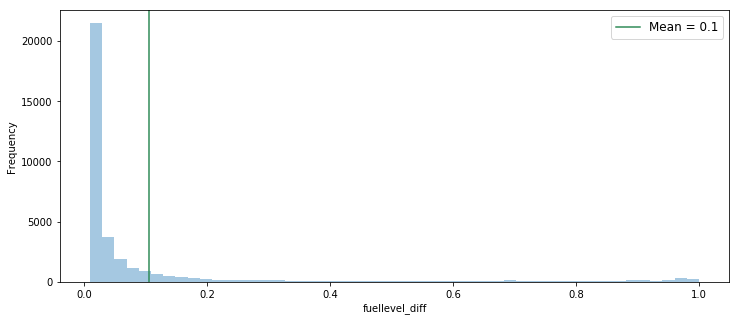

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fuellevel_diff = filtered_fueling_df['fuellevel_diff']

fig = plt.figure(figsize=(12,5))
sns.distplot(fuellevel_diff, kde=False)
plt.axvline(fuellevel_diff.mean(), label='Mean = {:2.1f}'.format(fuellevel_diff.mean()), color='seagreen')
plt.ylabel('Frequency')
plt.legend(loc=0, fontsize=12);

* Fuel-level increases appear to be exponentially distributed with a strong right-skew and a quickly decaying tail. The vast majority of these events are less than 0.1, while the most frequent fuel-level increase (the mode) is 0.01---confirming the data is noisy. Moreover, I suspect many (if not most) of the events to the left of the green line (the mean) are noise. After all, who would put such a small amount of fuel in their tank to then be later inconvenienced by another fueling stop? Not many, I'd imagine.

In [13]:
fuel_probs = filtered_fueling_df['fuellevel_diff'].value_counts(normalize=True)
fuel_probs

0.01    0.487255
0.02    0.109326
0.03    0.062071
0.04    0.041779
0.05    0.030299
0.06    0.023572
0.07    0.018930
0.08    0.014232
0.09    0.012981
0.10    0.012425
0.11    0.009785
0.12    0.008339
0.13    0.007366
0.14    0.006393
0.15    0.006004
0.98    0.005949
0.16    0.005365
1.00    0.004309
0.17    0.004225
0.18    0.004031
0.19    0.003864
0.20    0.003030
0.21    0.002891
0.91    0.002808
0.96    0.002752
0.22    0.002530
0.23    0.002391
0.97    0.002335
0.27    0.002196
0.24    0.002168
          ...   
0.61    0.001279
0.67    0.001279
0.39    0.001251
0.73    0.001251
0.64    0.001223
0.45    0.001223
0.44    0.001223
0.71    0.001195
0.51    0.001195
0.41    0.001195
0.82    0.001167
0.37    0.001167
0.86    0.001167
0.33    0.001167
0.88    0.001167
0.77    0.001112
0.93    0.001112
0.62    0.001084
0.46    0.001084
0.42    0.001056
0.68    0.001028
0.80    0.001028
0.84    0.001001
0.53    0.001001
0.75    0.000973
0.66    0.000945
0.78    0.000945
0.59    0.0009

In [14]:
import scipy.stats as stats

print(stats.describe(fuellevel_diff))
print('')
print('mode:', fuellevel_diff.mode()[0])
print('')
print('Percentiles')
print(50*'-')
print(fuellevel_diff.quantile([.1, .25, .5, .75, .9]))

DescribeResult(nobs=35975, minmax=(0.01, 1.0), mean=0.10627296733842946, variance=0.04826501582978641, skewness=2.78659204335666, kurtosis=6.818000451368363)

mode: 0.01

Percentiles
--------------------------------------------------
0.10    0.01
0.25    0.01
0.50    0.02
0.75    0.06
0.90    0.35
Name: fuellevel_diff, dtype: float64


* 50% of all observations are 0.01, while 75% of these observations are less than or equal to 0.06.
* 90% of these observations are less than or equal to 0.35.

I think it's safe to assume events with a large fuel-level increase have a higher likelihood of being fueling events than those with small increases in fuel-level. That is to say, events in the tail (with low probability) are more likely to be true-positives whereas events in the head (with high probability) are more likely to be false-positives. My thinking is this: (1) I want a number between 0 and 1 quantifying the likelihood that an observed fuel-level increase is a fueling event and (2) a way to convert this likelihood to a binary variable: fuel-event or not. To achieve this, I do the following.

1. Find a function that maps higher probability events to smaller numbers and lower probability events to larger numbers. Formally, this function $f$ satisfies the property of **antitonicity**  in the probability of events under observation. That is, for random variates $X$ and $Y$,
<br/><br/>
<center>$X \leq Y \ \text{implies} \ f(X) \geq f(Y)$<center/>
    

2. Transform the fuel-level increase probabilties with $f$ and divide by the maximum to obtain a number between 0 and 1. I.e., the likelihood the observation is, in fact, a fueling event.

The set of tools required to achieve the above come from [Information theory](https://en.wikipedia.org/wiki/Information_theory), and the function I'm after is the [Information content](https://en.wikipedia.org/wiki/Information_content).

# Information Content

Given a random variate $X$ with probability mass function $p_{X}(x)$, the information content (measured in bits) of observing $X$ take the value $x$ is defined as follows:
<br/><br/>

<center>$I_{X}(x) = \log_{2}\Bigg( \dfrac{1}{p_{X}(x)} \Bigg)$<center/>


The information content quantifies how "surprising" an observation is. The more surprising (i.e., less probable) an event is, the more information we gain from its observation. **My strategy is to use the information content to distinguish the noise from the signal**. Below I map the fuel-level probabilities to each fuel-level increase and transform the probabilities to bits with the information content  $I_{X}(x)$.

In [15]:
import numpy as np

fuel_probs = fuel_probs.to_dict()

filtered_fueling_df['probability'] = filtered_fueling_df.loc[:,'fuellevel_diff'].map(fuel_probs)

filtered_fueling_df['information_content'] = -np.log2(filtered_fueling_df['probability']).round(2)
filtered_fueling_df.head(10)

,r,timestamp,fuellevel_diff,probability,information_content
5,1,2017-01-04 13:21:37,0.96,0.002752,8.51
41,1,2017-01-04 21:14:38,0.05,0.030299,5.04
70,1,2017-01-09 11:18:24,0.74,0.001723,9.18
98,1,2017-01-26 06:31:28,0.96,0.002752,8.51
100,1,2017-01-26 06:33:28,0.02,0.109326,3.19
133,1,2017-01-26 07:33:56,0.06,0.023572,5.41
168,1,2017-01-26 12:02:39,0.01,0.487255,1.04
177,1,2017-02-02 04:54:30,0.96,0.002752,8.51
212,1,2017-02-23 06:41:33,0.94,0.001529,9.35
243,1,2017-02-23 07:35:05,0.02,0.109326,3.19


In [16]:
min_info = filtered_fueling_df['information_content'].min()
max_info = filtered_fueling_df['information_content'].max()

print("minimum information content:", min_info, "bits")
print("maximum information content:", max_info, "bits")

minimum information content: 1.04 bits
maximum information content: 10.28 bits


Next, I divide the ```information_content``` column by the maximum (10.28 bits) and obtain the likelihood that each observation is a fueling event.

In [17]:
filtered_fueling_df['fueling_prob'] = filtered_fueling_df.loc[:,'information_content']/max_info
filtered_fueling_df.head(10)

,r,timestamp,fuellevel_diff,probability,information_content,fueling_prob
5,1,2017-01-04 13:21:37,0.96,0.002752,8.51,0.827821
41,1,2017-01-04 21:14:38,0.05,0.030299,5.04,0.490272
70,1,2017-01-09 11:18:24,0.74,0.001723,9.18,0.892996
98,1,2017-01-26 06:31:28,0.96,0.002752,8.51,0.827821
100,1,2017-01-26 06:33:28,0.02,0.109326,3.19,0.310311
133,1,2017-01-26 07:33:56,0.06,0.023572,5.41,0.526265
168,1,2017-01-26 12:02:39,0.01,0.487255,1.04,0.101167
177,1,2017-02-02 04:54:30,0.96,0.002752,8.51,0.827821
212,1,2017-02-23 06:41:33,0.94,0.001529,9.35,0.909533
243,1,2017-02-23 07:35:05,0.02,0.109326,3.19,0.310311


Finally, I label fuel-level increases with a probability above 0.5 as a fueling event and discard the rest. This approach is *ad hoc* and certainly not the most sophisticated of ways to classify fueling events. A better approach would be to use logistic regression with the y-axis the fueling probabilities and the x-axis the fuel-level increases.

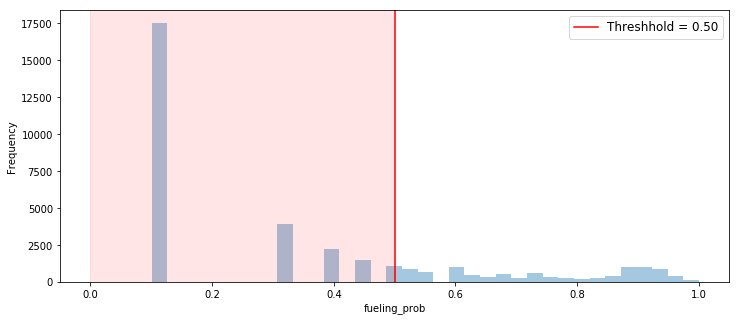

In [18]:
fueling_prob = filtered_fueling_df['fueling_prob']
fueling_prob_mean = fueling_prob.mean()

fig = plt.figure(figsize=(12,5))
sns.distplot(fueling_prob, kde=False)
plt.axvline(0.5, label='Threshhold = 0.50', color='red')
plt.axvspan(0, 0.5, alpha=0.1, color='red')
plt.ylabel('Frequency')
plt.legend(loc=0, fontsize=12);

In [19]:
print(stats.describe(fueling_prob))
print('')
print(50*'-')
print(fueling_prob.quantile([.1, .25, .5, .75, .9]))

DescribeResult(nobs=35975, minmax=(0.10116731517509729, 1.0), mean=0.3443037885691263, variance=0.08159958546955984, skewness=0.8191605287041915, kurtosis=-0.6726682459236804)

--------------------------------------------------
0.10    0.101167
0.25    0.101167
0.50    0.310311
0.75    0.526265
0.90    0.860895
Name: fueling_prob, dtype: float64


In [20]:
def fuel_event(fuel_prob):
    if fuel_prob > 0.5:
        return 'Y'
    return 'N'

filtered_fueling_df['fuel_event'] = filtered_fueling_df.loc[:, 'fueling_prob'].apply(fuel_event)
filtered_fueling_df

,r,timestamp,fuellevel_diff,probability,information_content,fueling_prob,fuel_event
5,1,2017-01-04 13:21:37,0.96,0.002752,8.51,0.827821,Y
41,1,2017-01-04 21:14:38,0.05,0.030299,5.04,0.490272,N
70,1,2017-01-09 11:18:24,0.74,0.001723,9.18,0.892996,Y
98,1,2017-01-26 06:31:28,0.96,0.002752,8.51,0.827821,Y
100,1,2017-01-26 06:33:28,0.02,0.109326,3.19,0.310311,N
133,1,2017-01-26 07:33:56,0.06,0.023572,5.41,0.526265,Y
168,1,2017-01-26 12:02:39,0.01,0.487255,1.04,0.101167,N
177,1,2017-02-02 04:54:30,0.96,0.002752,8.51,0.827821,Y
212,1,2017-02-23 06:41:33,0.94,0.001529,9.35,0.909533,Y
243,1,2017-02-23 07:35:05,0.02,0.109326,3.19,0.310311,N


Some of the fuel-level increases labeled as fueling events are odd to say the least. Some examples:

* rows 284 and 291 are seperated by about 6 minutes yet both record an increase in fuel by ~73%.

* rows 509192 and 509199 are seperated by about 3 hours yet both record an increase in fuel by ~65%.

* rows 509490 and 509501 are seperated by about 20 minutes yet both record an increase in fuel by ~35%.

 The above events are highly suspicious, as fuel fraud and fuel theft are a severe problem for fleet managers.  Either there is an error in my analysis, the telematics device/fuel level sensor, or fuel is being siphoned from the gas tank?

In [21]:
fueling_events = filtered_fueling_df[filtered_fueling_df['fuel_event'] == 'Y'].shape[0]

print("number of fueling events:", fueling_events)
print("percentage of data populated by fueling events:", 
      str(round(fueling_events/df.shape[0], 2)*100) + '%')

number of fueling events: 9687
percentage of data populated by fueling events: 2.0%


2% of the data being populated by fueling events is more believable than 7.1% but still seems too high. 